# Flight Fare Prediction


*This project aims to predict airline ticket prices by addressing a regression problem, involving steps such as exploratory data analysis (EDA), feature engineering, data preprocessing, model training and tuning, and generating a Kaggle submission.*


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sunburst-png/sunburst.png.png
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv


# 1. Importing Libraries

*We begin this process by importing all the necessary libraries required to complete the entire pipeline.*

In [2]:

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

# 2. Loading files

*Loading the datasets into pandas DataFrames.*  
  
*train.csv: training data along with target variable (price).*
  
*test.csv: test data with price*
  
*sample_submission.csv: file showing the format for kaggle submission.*

In [3]:
warnings.filterwarnings("ignore")

submission_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/sample_submission.csv')
train_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv')
test_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv')


train_df.head()

,id,airline,flight,source,departure,stops,arrival,destination,class,duration,days_left,price
0,0,Vistara,UK-930,Mumbai,Early_Morning,one,Night,Chennai,Business,NaN,40.0,64173
1,1,Air_India,AI-539,Chennai,Evening,one,Morning,Mumbai,Economy,16.08,26.0,4357
2,2,SpiceJet,SG-8107,Delhi,Early_Morning,zero,Morning,Chennai,Economy,2.92,25.0,3251
3,3,NaN,0.00E+00,Hyderabad,Early_Morning,zero,Morning,Bangalore,Economy,1.50,22.0,1776
4,4,Air_India,AI-569,Chennai,Early_Morning,one,Morning,Bangalore,Economy,4.83,20.0,3584


# 3. Data Processsing

*Understaning the dataset.*

## 3.1 Identifying Data types of Columns

*Indentifying the data types of columns helps us in differentiating different type of features like datetime, numerical and categorical.*

In [4]:
train_df.dtypes

id               int64
airline         object
flight          object
source          object
departure       object
stops           object
arrival         object
destination     object
class           object
duration       float64
days_left      float64
price            int64
dtype: object

## 3.2 Descriptive Statistics 

In [5]:
train_df.describe()

,id,duration,days_left,price
count,40000.00000,36987.000000,35562.000000,40000.00000
mean,19999.50000,12.004088,26.197936,20801.49025
std,11547.14972,7.108063,13.469232,22729.14842
min,0.00000,0.830000,1.000000,1105.00000
25%,9999.75000,6.670000,15.000000,4687.00000
50%,19999.50000,11.080000,26.000000,7353.00000
75%,29999.25000,15.920000,38.000000,42521.00000
max,39999.00000,47.080000,49.000000,114704.00000


# 4. Data Cleaning and Preprocessing



## 4.1 Identifying and Handling Missing Values

*In most cases, we need a complete dataset i.e., dataset without any missing values to get accurate results. Based on the importance of the data we either remove the affected rows/columns or use statistical methods to impute the missing values.*

In [6]:
#identifying missing values
print('Missing values in training dataset:\n', train_df.isnull().sum())
print('\n')
print('Missing values in test dataset:\n', test_df.isnull().sum())


Missing values in training dataset:
 id                0
airline        4613
flight            0
source            0
departure      4792
stops          2319
arrival           0
destination       0
class             0
duration       3013
days_left      4438
price             0
dtype: int64


Missing values in test dataset:
 id               0
airline        548
flight           0
source           0
departure      920
stops          651
arrival          0
destination      0
class            0
duration       582
days_left      696
dtype: int64


In [7]:
#Handling missing values

for col in ['duration', 'days_left']:
    train_df[col].fillna(train_df[col].median(), inplace=True)
    test_df[col].fillna(test_df[col].median(), inplace=True)

for col in ['airline', 'flight', 'source', 'destination', 'departure', 'arrival', 'stops', 'class']:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)
    test_df[col].fillna(test_df[col].mode()[0], inplace=True)

# Ensure 'price' is numeric and drop rows with missing prices
train_df['price'] = pd.to_numeric(train_df['price'], errors='coerce')
train_df = train_df.dropna(subset=['price'])

print('After Imputation\n')
print('Training dataset missing values:', train_df.isnull().sum().sum())
print('Test dataset missing values:', test_df.isnull().sum().sum())


After Imputation

Training dataset missing values: 0
Test dataset missing values: 0


## 4.2 Handling Duplicates

*Identifying and removing duplicate entries in training and test datasets.*

In [8]:
# Identifying Duplicates

print('Duplicate rows in training dataset:', train_df.duplicated().sum() )
print('Duplicate rows in training dataset:', test_df.duplicated().sum() )

# Handling Duplicates

train_df.drop_duplicates(inplace = True)
test_df.drop_duplicates(inplace = True)

print('\n')
print('Training dataset:', train_df.shape)
print('Test dataset:', test_df.shape)

Duplicate rows in training dataset: 0
Duplicate rows in training dataset: 0


Training dataset: (40000, 12)
Test dataset: (10000, 11)


## 4.3 Identifying and Handling Outliers


*Data points which significantly differ from rest of the dataset are known as Outliers. Outliers can distort the performance of the model. We handle them using the InterQuartile Range(IQR) techinique.*


 Number of outliers in 'price': 14


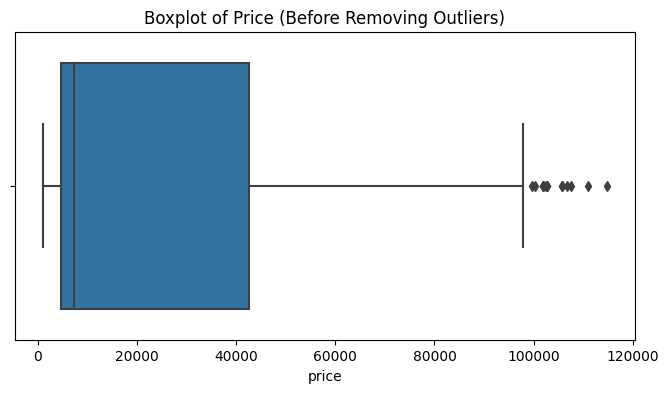

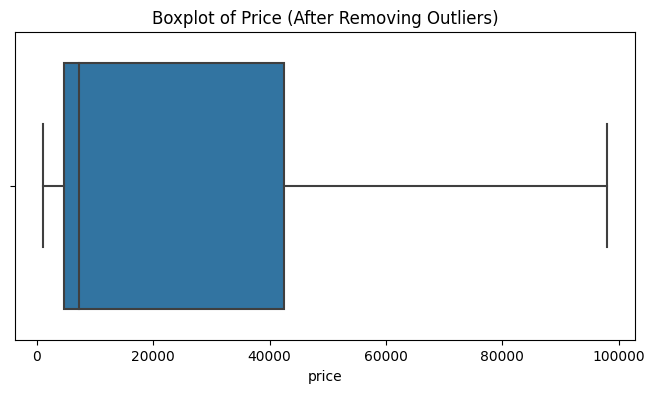

In [9]:
def handle_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lb = Q1 - 1.5 * IQR
    ub = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lb) | (df[col] > ub)]
    return outliers

price_outliers = handle_outliers(train_df, 'price')
print(f" Number of outliers in 'price': {price_outliers.shape[0]}")

plt.figure(figsize=(8, 4))
sns.boxplot(x=train_df['price'])
plt.title("Boxplot of Price (Before Removing Outliers)")
plt.show()


train_df = train_df[~train_df.index.isin(price_outliers.index)]


plt.figure(figsize=(8, 4))
sns.boxplot(x=train_df['price'])
plt.title("Boxplot of Price (After Removing Outliers)")
plt.show()

# 5. Exploratory Data Analysis (EDA)

### 5.1  Sunburst Chart: Airline -> Source -> Stops

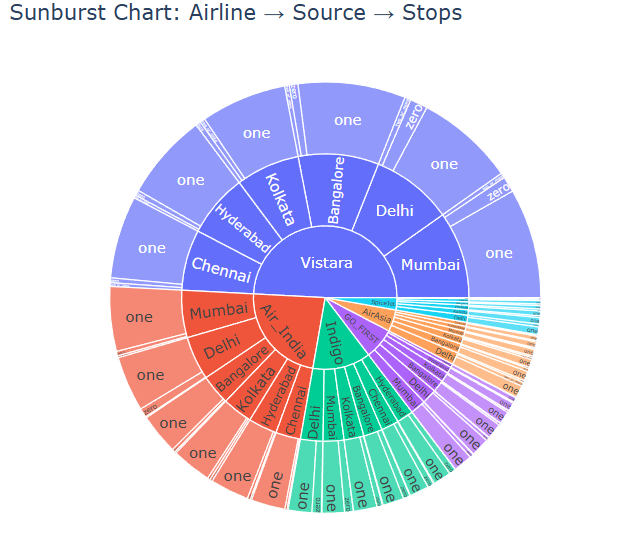

In [10]:
import plotly.express as px
from IPython.display import Image, HTML, display

fig = px.sunburst(train_df, path=['airline', 'source', 'stops'],
                  title="Sunburst Chart: Airline → Source → Stops")

fig.write_html("sunburst_interactive.html")

display(Image("/kaggle/input/sunburst-png/sunburst.png.png"))

display(HTML('<a href="sunburst_interactive.html" target="_blank">🔗 Click to View Interactive Sunburst Chart</a>'))


#### Insight

*This chart reveals that Vistara dominates the dataset, offering flights from all major source cities, mostly with one stop. Similarly, Air India and IndiGo also operate across multiple routes but show less volume compared to Vistara. The chart highlights that most flights, regardless of airline or route, involve one stop, suggesting that non-stop or multi-stop flights are less common in this dataset.*

### 5.2 Ticket Price Distribution Across Number of Stops

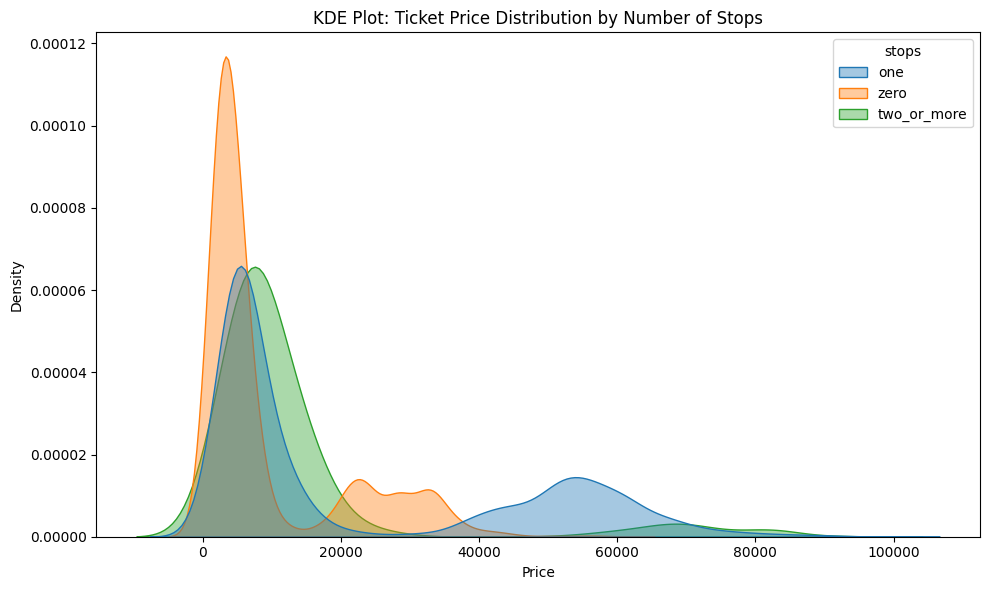

In [11]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data= train_df, x='price', hue='stops', fill=True, common_norm=False, alpha=0.4)
plt.title('KDE Plot: Ticket Price Distribution by Number of Stops')
plt.xlabel('Price')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

#### Insight

*This plot shows that non-stop flights generally have a lower and tighter price range, indicating more consistent pricing. In contrast, flights with one or more stops tend to have a wider spread and higher peak prices, suggesting greater price variability and often higher costs. This reflects how convenience (fewer stops) often correlates with more predictable and affordable pricing.*

### 5.3 Price Distribution by Airline

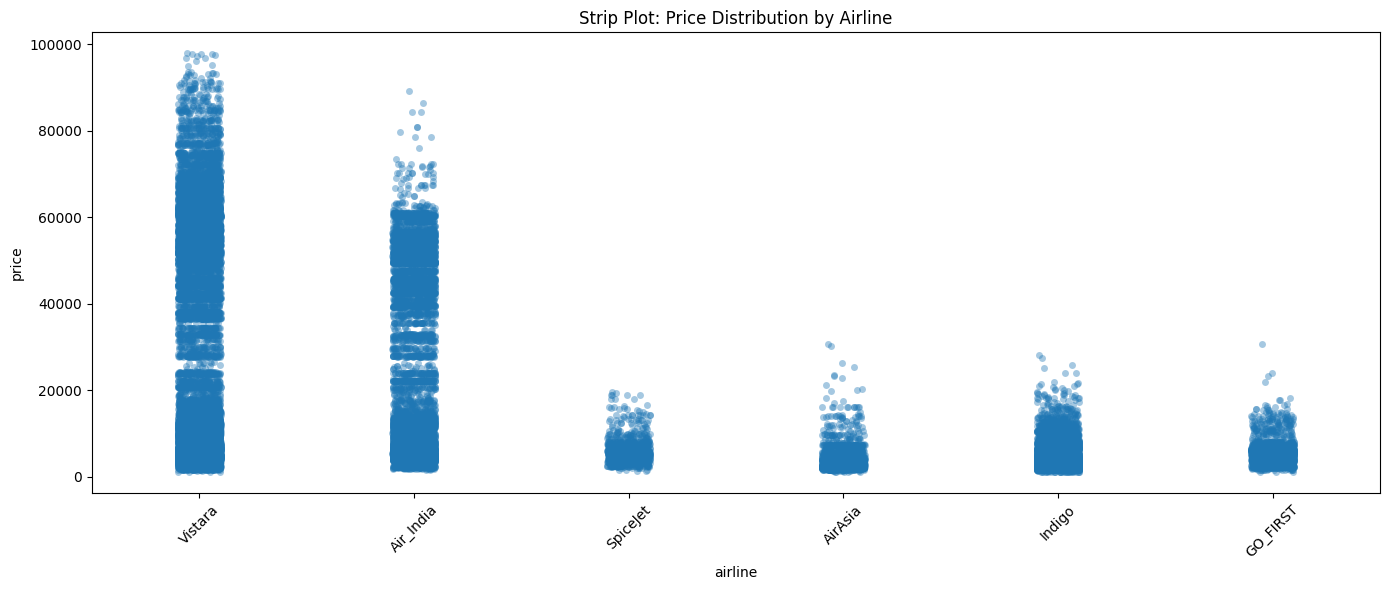

In [12]:
plt.figure(figsize=(14, 6))
sns.stripplot(x='airline', y='price', data= train_df, jitter=True, alpha=0.4)
plt.xticks(rotation=45)
plt.title('Strip Plot: Price Distribution by Airline')
plt.tight_layout()
plt.show()

#### Insight

*The strip plot uncovers that low-cost carriers tend to cluster tightly at the lower end of the price spectrum, indicating a focus on price-sensitive customers and standardized offerings. In contrast, full-service airlines display a much wider spread in ticket prices, with visible clusters at both low and high ends, suggesting the presence of multiple service classes (e.g., economy and business) or dynamic pricing based on demand and route. Additionally, the presence of outliers or high-price spikes in certain airlines can reflect premium routes or flexible fare structures, giving insights into how each airline segments its customer base and monetizes different travel segments.*

### 5.4 Ticket Price Variation with Time of Day

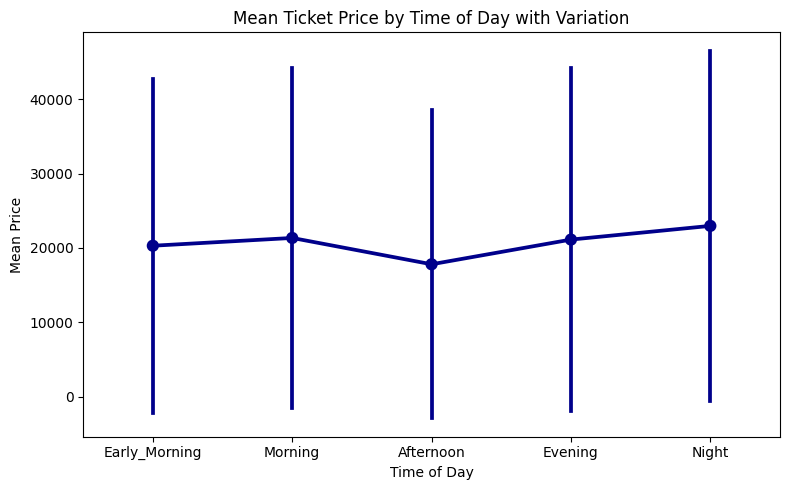

In [13]:
time_order = ['Early_Morning', 'Morning', 'Afternoon', 'Evening', 'Night']

plt.figure(figsize=(8, 5))
sns.pointplot(x='departure', y='price', data=train_df, order=time_order, estimator='mean', ci='sd', color='darkblue')
plt.title('Mean Ticket Price by Time of Day with Variation')
plt.xlabel('Time of Day')
plt.ylabel('Mean Price')
plt.tight_layout()
plt.show()



#### Insight

*Afternoon flights tend to have the lowest average ticket prices, while night flights are generally the most expensive. This pattern suggests lower demand for midday travel and a higher concentration of premium or long-haul routes at night. The wide variation in prices across all time slots indicates that factors like class, airline, and number of stops also play a significant role in pricing.*

# 6. Feature Scaling and Encoding

### 6.1 Feature Categorization

*Categorizing features into categorical and numerical types to ensure it undergoes correct preprocessing treatment.*

In [14]:
categorical_features = train_df.select_dtypes(include='object').columns.tolist()
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['airline', 'flight', 'source', 'departure', 'stops', 'arrival', 'destination', 'class']
Numerical Features: ['id', 'duration', 'days_left', 'price']


### 6.2 Encoding Categorical Features

*Converting categorical varibles into numberical using OneHotEncoding:*

In [15]:
cat_cols_to_encode = ['airline', 'flight', 'source', 'destination', 'class', 'stops', 'arrival', 'departure']

train_encoded = pd.get_dummies(train_df, columns=cat_cols_to_encode)
test_encoded = pd.get_dummies(test_df, columns=cat_cols_to_encode)

test_encoded = test_encoded.reindex(columns=train_encoded.columns.drop('price'), fill_value = 0)


### 6.3 Scaling Numerical Features

*We are using MinMaxScaler to scale the numerical features and rescale them to a range between 0 and 1.*

In [16]:
scaler = MinMaxScaler()
num_cols = ['duration', 'days_left']
train_encoded[num_cols] = scaler.fit_transform(train_encoded[num_cols])
test_encoded[num_cols] = scaler.transform(test_encoded[num_cols])

# 7. Train-Test Split

* X_train, y_train: used to train the model
* X_val, y_val: used to evaluate model performance

random_state = 42 ensures the reproducibility of the split

In [17]:
X = train_encoded.drop(['price', 'id'], axis=1)
y = train_encoded['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Model Building

*We implemented and trained seven different regression models. Each model was fit using the training dataset and evaluated on the test set to gauge performance.*

#### The models include:

#### 1. Linear Regression
  
#### 2. Lasso Regression
  
#### 3. Decision Tree Regressor
  
#### 4. Random Forest Regressor
  
#### 5. Gradient Boosting Regressor
  
#### 6. AdaBoost Regressor
  
#### 7. KNN Regressor

In [18]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=10, random_state=42, n_jobs = 1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    
    rmse = mean_squared_error(y_val, preds, squared=False)
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    
    results.append((name, rmse, mae, r2))

results_df = pd.DataFrame(results, columns = ['Model', 'RMSE', 'MAE', 'R² Score'])
results_df = results_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

In [19]:
display(results_df)

,Model,RMSE,MAE,R² Score
0,Random Forest,3.527636e+03,1.765912e+03,9.757580e-01
1,Decision Tree,4.356796e+03,1.887368e+03,9.630227e-01
2,Gradient Boosting,5.172054e+03,3.121105e+03,9.478892e-01
3,KNN Regressor,5.664805e+03,3.397076e+03,9.374869e-01
4,AdaBoost,6.100497e+03,3.813251e+03,9.275011e-01
5,Lasso Regression,6.440475e+03,4.441417e+03,9.191952e-01
6,Linear Regression,1.025232e+15,3.674484e+13,-2.047603e+21


# 9. Hyperparameter Tuning

*Hyperparameter tuning is the process of finding the best combination of model settings that are defined before training and not learned from the data. In this task, we use GridSearchCV to perform an exhaustive search over specified hyperparameter values for three different models to identify the optimal configuration.*

### 9.1 Random Forest Regressor using RandomizedSearchCV 

In [20]:
from scipy.stats import randint

rf_params = {
    'n_estimators': randint(20,60),
    'max_depth': [5, 10, None],
    'min_samples_split': [2,5]
}

rf = RandomForestRegressor(n_jobs= -1)
rf_random = RandomizedSearchCV(
    rf, rf_params, n_iter = 5, cv = 2,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=1
)

rf_random.fit(X_train, y_train)

print('Best RF RMSE:', -rf_random.best_score_)
print('Best RF Parameters:', rf_random.best_params_)
rf_val_preds = rf_random.predict(X_val)
rf_val_r2 = r2_score(y_val, rf_val_preds)
print("Random Forest Validation R²:", round(rf_val_r2, 3))

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best RF RMSE: 3738.4495669256703
Best RF Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 48}
Random Forest Validation R²: 0.978


### 9.2 Decision Tree Regressor using GridSearchCV

In [21]:
dt_params = {
    'max_depth': [10,20,30],
    'min_samples_split': [2,5,10]
}

dt = DecisionTreeRegressor(random_state=42)

dt_grid = GridSearchCV(
    dt,
    dt_params,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

X_val = X_val[X_train.columns]

dt_grid.fit(X_train, y_train)

print("Best DT RMSE:", -dt_grid.best_score_)
print("Best DT Parameters:", dt_grid.best_params_)
val_preds = dt_grid.predict(X_val)
print("Validation R²:", round(r2_score(y_val, val_preds), 3))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best DT RMSE: 4284.978461619393
Best DT Parameters: {'max_depth': 30, 'min_samples_split': 10}
Validation R²: 0.968


### 9.3 GradientBoosting Regressor using RandomizedSearchCV

In [22]:
gb_params = {
    'n_estimators': [100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

gb_random = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_params,
    n_iter=5,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

X_val = X_val[X_train.columns]

gb_random.fit(X_train, y_train)

print("Best GB RMSE (CV):", -gb_random.best_score_)
print("Best GB Parameters:", gb_random.best_params_)

val_preds = gb_random.predict(X_val)
val_r2 = r2_score(y_val, val_preds)

print("Validation R²:", round(val_r2, 3))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best GB RMSE (CV): 4518.923426354636
Best GB Parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
Validation R²: 0.959


# Model Comparsion and Evaluation

*Evaluating the models based on the three key metrics:*

1. RMSE (Root Mean Squared Error) - penalizes larger errors more

2. MAE (Mean Absolute Error) - gives equal weight to all errors

3. R² Score (Coefficient of Determination) - how well predicts explain variance in target
  
### Model Performance Table
  
|       Model 	      |    RMSE	  |   MAE	|  R² Score |
|:-------------------:|----------:|--------:|----------:|
|Random Forest	      |  3573.78  |	1843.42	|  0.975120 |
|Decision Tree	      |  4462.85  |	1989.30	|  0.961200 |
|Gradient Boosting    |	 5173.26  | 3122.05 |  0.947865 |
|AdaBoost	          |  6100.49  |	3813.25	|  0.927501 |
|Linear Regression    |	 6416.61  | 4469.20 |  0.919793 |
|Lasso Regression     |	 6440.47  | 4441.73 |  0.919195 |
|KNN Regressor	      |  24398.66 |	19768.03| -0.159667 | 


### Sorted models by RMSE (lower is better)

In [23]:
results_df_sorted = results_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
print(results_df_sorted)

               Model          RMSE           MAE      R² Score
0      Random Forest  3.527636e+03  1.765912e+03  9.757580e-01
1      Decision Tree  4.356796e+03  1.887368e+03  9.630227e-01
2  Gradient Boosting  5.172054e+03  3.121105e+03  9.478892e-01
3      KNN Regressor  5.664805e+03  3.397076e+03  9.374869e-01
4           AdaBoost  6.100497e+03  3.813251e+03  9.275011e-01
5   Lasso Regression  6.440475e+03  4.441417e+03  9.191952e-01
6  Linear Regression  1.025232e+15  3.674484e+13 -2.047603e+21


# 11. Final Model Training

*After evaluating and fine-tuning hyperparameters of all the models, the Random Forest Regressor has the least RMSE value. So, we retrain this optimised model on complete training set before generating final predictions.*

In [24]:
final_model = RandomForestRegressor(
    n_estimators=48,
    max_depth=None,
    min_samples_split=5,
    random_state=42
)
final_model.fit(X, y)

RandomForestRegressor(min_samples_split=5, n_estimators=48, random_state=42)

# 12. Submission File

#### Final Predictions

The optimised RandomForest model is used to predict the flight prices for the test set.

In [25]:
final_predictions = final_model.predict(test_encoded.drop('id', axis=1))

### Submission File

*Format predictions according to submission structure, using the sample_submission.csv as reference.*

In [26]:
submission_df['price'] = final_predictions.astype(int)
submission_df.to_csv('submission.csv', index=False)

submission_df

,id,price
0,0,4454
1,1,12370
2,2,3828
3,3,60529
4,4,49960
...,...,...
9995,9995,4571
9996,9996,8170
9997,9997,82506
9998,9998,56590


In [27]:
from IPython.display import FileLink
FileLink("submission.csv")

/kaggle/working/submission.csv